In [1]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

# Add the root directory to the Python path
sys.path.append(os.getcwd())

from binance_provider import get_historical_data
from strategy import RunOptions, EWMACrossFactor, MACDDifferenceFactor, BollingerBandFactor, RsiFactor
from model import train_conv_lstm

In [2]:
symbol = 'ETHUSDT'
timeframe = '1h'
eth_data = get_historical_data('ETHUSDT', timeframe, datetime(2018, 1, 1), datetime.now()) 
eth_data

open_time     open     high      low    close  \
open_time                                                                     
2019-11-27 07:00:00 2019-11-27 07:00:00   146.00   146.00   146.00   146.00   
2019-11-27 08:00:00 2019-11-27 08:00:00   125.03   145.01   125.03   133.00   
2019-11-27 09:00:00 2019-11-27 09:00:00   133.00   133.00   133.00   133.00   
2019-11-27 10:00:00 2019-11-27 10:00:00   142.20   144.52   142.10   142.62   
2019-11-27 11:00:00 2019-11-27 11:00:00   142.70   146.92   142.22   146.58   
...                                 ...      ...      ...      ...      ...   
2024-10-12 17:00:00 2024-10-12 17:00:00  2471.73  2486.36  2468.28  2468.48   
2024-10-12 18:00:00 2024-10-12 18:00:00  2468.48  2480.20  2467.21  2474.71   
2024-10-12 19:00:00 2024-10-12 19:00:00  2474.70  2481.00  2466.35  2468.71   
2024-10-12 20:00:00 2024-10-12 20:00:00  2468.71  2473.23  2465.00  2471.30   
2024-10-12 21:00:00 2024-10-12 21:00:00  2471.31  2472.35  2468.68  2470.28   

                        volume              close_time  quote_asset_volume  \
open_time                                                                    
2019-11-27 07:00:00      0.010 2019-11-27 07:59:59.999        1.460000e+00   
2019-11-27 08:00:00      0.080 2019-11-27 08:59:59.999        1.092040e+01   
2019-11-27 09:00:00      0.000 2019-11-27 09:59:59.999        0.000000e+00   
2019-11-27 10:00:00   2832.710 2019-11-27 10:59:59.999        4.040542e+05   
2019-11-27 11:00:00   9079.800 2019-11-27 11:59:59.999        1.312100e+06   
...                        ...                     ...                 ...   
2024-10-12 17:00:00  97333.321 2024-10-12 17:59:59.999        2.410460e+08   
2024-10-12 18:00:00  39075.237 2024-10-12 18:59:59.999        9.666224e+07   
2024-10-12 19:00:00  43058.565 2024-10-12 19:59:59.999        1.064789e+08   
2024-10-12 20:00:00  28007.484 2024-10-12 20:59:59.999        6.915979e+07   
2024-10-12 21:00:00   4879.898 2024-10-12 21:59:59.999        1.205573e+07   

                     number_of_trades  taker_buy_base_asset_volume  \
open_time                                                            
2019-11-27 07:00:00                 1                        0.000   
2019-11-27 08:00:00                 5                        0.010   
2019-11-27 09:00:00                 0                        0.000   
2019-11-27 10:00:00               387                     2595.490   
2019-11-27 11:00:00              1107                     5932.530   
...                               ...                          ...   
2024-10-12 17:00:00            107577                    50038.756   
2024-10-12 18:00:00             64517                    20564.672   
2024-10-12 19:00:00             70634                    21318.594   
2024-10-12 20:00:00             51009                    14696.333   
2024-10-12 21:00:00              9514                     2143.843   

                     taker_buy_quote_asset_volume  
open_time                                          
2019-11-27 07:00:00                  0.000000e+00  
2019-11-27 08:00:00                  1.450100e+00  
2019-11-27 09:00:00                  0.000000e+00  
2019-11-27 10:00:00                  3.702431e+05  
2019-11-27 11:00:00                  8.536526e+05  
...                                           ...  
2024-10-12 17:00:00                  1.239358e+08  
2024-10-12 18:00:00                  5.087327e+07  
2024-10-12 19:00:00                  5.271619e+07  
2024-10-12 20:00:00                  3.629348e+07  
2024-10-12 21:00:00                  5.295965e+06  

[42758 rows x 11 columns]

In [3]:
time_scaler = 24 if timeframe == '1h' else 1 # This works only for 1h and 1d timeframes
ma_cross = EWMACrossFactor(slow_window= 12 * time_scaler,fast_window=  26 * time_scaler)
macd = MACDDifferenceFactor(slow_window= 12 * time_scaler, fast_window= 26 * time_scaler, signal_window= 9* time_scaler, short_signal=0, is_binary=True)
bollinger_band = BollingerBandFactor(window= 20 * time_scaler, low_pos=0)
rsi = RsiFactor(14 * time_scaler, ovr_bought_lvl=50, ovr_sold_lvl=47)


signal_df = eth_data[['close']].copy()
signal_df['ma_signal'] = await ma_cross.get_signal(signal_df['close'])
signal_df['macd_signal'] = await macd.get_signal(signal_df['close'])
signal_df['bband_signal']  = await bollinger_band.get_signal(signal_df['close'])
signal_df['rsi_signal'] = await rsi.get_signal(signal_df['close'], )



c:\code\crypto\ml-lecture\strategy.py:119: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  lambda x: self.ovr_sold_pos if x['oversold'] else self.ovr_bought_pos if x['overbought'] else pd.NA, axis=1).ffill().fillna(0)


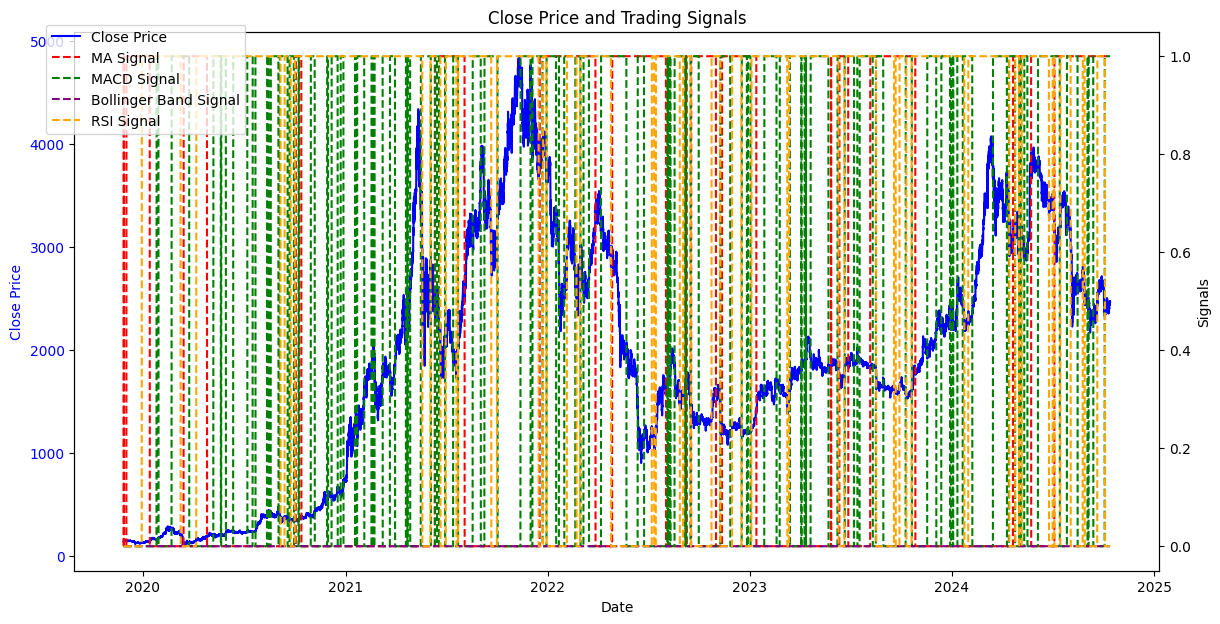

In [4]:


fig, ax1 = plt.subplots(figsize=(14, 7))

# Plot close price
ax1.plot(signal_df.index, signal_df['close'], color='blue', label='Close Price')
ax1.set_xlabel('Date')
ax1.set_ylabel('Close Price', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create a second y-axis for the signals
ax2 = ax1.twinx()
ax2.plot(signal_df.index, signal_df['ma_signal'], color='red', label='MA Signal', linestyle='--')
ax2.plot(signal_df.index, signal_df['macd_signal'], color='green', label='MACD Signal', linestyle='--')
ax2.plot(signal_df.index, signal_df['bband_signal'], color='purple', label='Bollinger Band Signal', linestyle='--')
ax2.plot(signal_df.index, signal_df['rsi_signal'], color='orange', label='RSI Signal', linestyle='--')
ax2.set_ylabel('Signals', color='black')
ax2.tick_params(axis='y', labelcolor='black')

# Add legends
fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))

plt.title('Close Price and Trading Signals')
plt.show()

In [5]:

# Calculate the log returns of the close price
signal_df['returns'] = np.log(signal_df['close'] / signal_df['close'].shift(1))
# Calculate if the returns went up (1) or down (-1)
signal_df['returns_direction'] = np.where(signal_df['returns'] > 0, 1, 0)

signal_df['volatility'] = signal_df['returns'].rolling(window=20).std()
signal_df['volume'] = eth_data['volume']

# Display the first few rows to verify
signal_df

close  ma_signal  macd_signal  bband_signal  \
open_time                                                            
2019-11-27 07:00:00   146.00          0            0             0   
2019-11-27 08:00:00   133.00          1            0             0   
2019-11-27 09:00:00   133.00          1            0             0   
2019-11-27 10:00:00   142.62          1            0             0   
2019-11-27 11:00:00   146.58          0            0             0   
...                      ...        ...          ...           ...   
2024-10-12 17:00:00  2468.48          1            1             0   
2024-10-12 18:00:00  2474.71          1            1             0   
2024-10-12 19:00:00  2468.71          1            1             0   
2024-10-12 20:00:00  2471.30          1            1             0   
2024-10-12 21:00:00  2470.28          1            1             0   

                     rsi_signal   returns  returns_direction  volatility  \
open_time                                                                  
2019-11-27 07:00:00           0       NaN                  0         NaN   
2019-11-27 08:00:00           0 -0.093257                  0         NaN   
2019-11-27 09:00:00           0  0.000000                  0         NaN   
2019-11-27 10:00:00           0  0.069835                  1         NaN   
2019-11-27 11:00:00           0  0.027388                  1         NaN   
...                         ...       ...                ...         ...   
2024-10-12 17:00:00           0 -0.001320                  0    0.002175   
2024-10-12 18:00:00           0  0.002521                  1    0.002112   
2024-10-12 19:00:00           0 -0.002427                  0    0.001912   
2024-10-12 20:00:00           0  0.001049                  1    0.001910   
2024-10-12 21:00:00           0 -0.000413                  0    0.001903   

                        volume  
open_time                       
2019-11-27 07:00:00      0.010  
2019-11-27 08:00:00      0.080  
2019-11-27 09:00:00      0.000  
2019-11-27 10:00:00   2832.710  
2019-11-27 11:00:00   9079.800  
...                        ...  
2024-10-12 17:00:00  97333.321  
2024-10-12 18:00:00  39075.237  
2024-10-12 19:00:00  43058.565  
2024-10-12 20:00:00  28007.484  
2024-10-12 21:00:00   4879.898  

[42758 rows x 9 columns]

# Feature Engineering
At this point we begin the feature engineering part


In [6]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from sklearn.utils import class_weight


data = signal_df.copy()

# Drop rows with NaN values
data.dropna(inplace=True)

# Data Preparation
features = ['close', 'ma_signal', 'macd_signal', 'bband_signal', 'rsi_signal', 'volatility', 'volume']
target = 'returns_direction'

# Define the window size for sequences
window_size = 5 * 24 if timeframe == '1h' else 24

# Normalize the features
scaler = MinMaxScaler()
data[features] = scaler.fit_transform(data[features])

# Create sequences for Conv-LSTM
def create_sequences(data, features, target, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[features].iloc[i:i + window_size].values)
        y.append(data[target].iloc[i + window_size])
    return np.array(X), np.array(y)

# Prepare training and testing datasets
X, y = create_sequences(data, features, target, window_size)

# Split the data into training and testing sets
split_idx = int(0.8 * len(X))
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

In [7]:
# Calculate class weights to handle class imbalance
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = dict(enumerate(class_weights))

# Model Definition
model = Sequential([
    Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(window_size, len(features))),
    BatchNormalization(),
    Dropout(0.2),
    LSTM(50, activation='tanh', return_sequences=False),
    Dropout(0.2),
    Dense(1, activation='sigmoid')  # Sigmoid activation for binary classification
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test), class_weight=class_weights_dict)

# Evaluate the model
eval_results = model.evaluate(X_test, y_test)
print(f'Test Loss: {eval_results[0]}, Test Accuracy: {eval_results[1]}')

c:\code\crypto\ml-lecture\venv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
1066/1066 ━━━━━━━━━━━━━━━━━━━━ 25s 21ms/step - accuracy: 0.5032 - loss: 0.7056 - val_accuracy: 0.4973 - val_loss: 0.6945
Epoch 2/10
1066/1066 ━━━━━━━━━━━━━━━━━━━━ 43s 22ms/step - accuracy: 0.4994 - loss: 0.6971 - val_accuracy: 0.5101 - val_loss: 0.6932
Epoch 3/10
1066/1066 ━━━━━━━━━━━━━━━━━━━━ 23s 22ms/step - accuracy: 0.5029 - loss: 0.6950 - val_accuracy: 0.5025 - val_loss: 0.6938
Epoch 4/10
1066/1066 ━━━━━━━━━━━━━━━━━━━━ 24s 23ms/step - accuracy: 0.5067 - loss: 0.6937 - val_accuracy: 0.4886 - val_loss: 0.6942
Epoch 5/10
1066/1066 ━━━━━━━━━━━━━━━━━━━━ 23s 22ms/step - accuracy: 0.4998 - loss: 0.6938 - val_accuracy: 0.4968 - val_loss: 0.6934
Epoch 6/10
1066/1066 ━━━━━━━━━━━━━━━━━━━━ 24s 22ms/step - accuracy: 0.5059 - loss: 0.6931 - val_accuracy: 0.4892 - val_loss: 0.6943
Epoch 7/10
1066/1066 ━━━━━━━━━━━━━━━━━━━━ 23s 22ms/step - accuracy: 0.5049 - loss: 0.6933 - val_accuracy: 0.5055 - val_loss: 0.6932
Epoch 8/10
1066/1066 ━━━━━━━━━━━━━━━━━━━━ 24s 22ms/step - accuracy: 0.4976 -

c:\code\crypto\ml-lecture\strategy.py:119: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  lambda x: self.ovr_sold_pos if x['oversold'] else self.ovr_bought_pos if x['overbought'] else pd.NA, axis=1).ffill().fillna(0)
c:\code\crypto\ml-lecture\strategy.py:119: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  lambda x: self.ovr_sold_pos if x['oversold'] else self.ovr_bought_pos if x['overbought'] else pd.NA, axis=1).ffill().fillna(0)
c:\code\crypto\ml-lecture\strategy.py:119: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecat

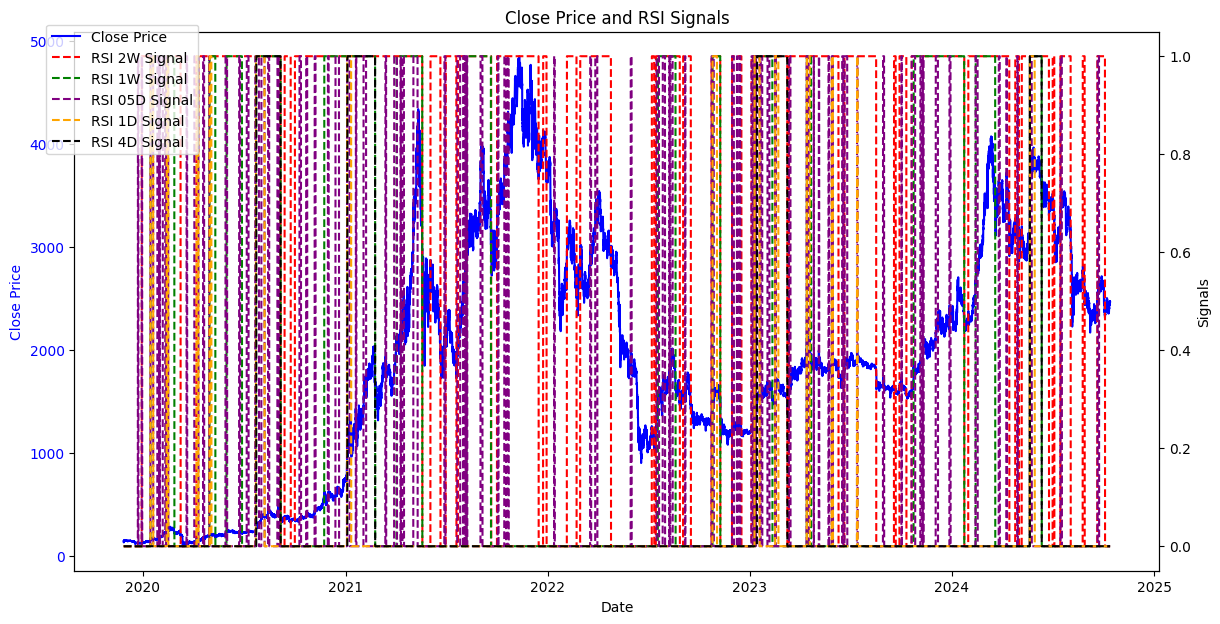

In [8]:
rsi_2w = RsiFactor(14 * time_scaler, ovr_bought_lvl=50, ovr_sold_lvl=47)
rsi_1w = RsiFactor(7 * time_scaler, ovr_bought_lvl=60, ovr_sold_lvl=45)
rsi_05d = RsiFactor(14 , ovr_bought_lvl=80, ovr_sold_lvl=40)
rsi_1d = RsiFactor(24 , ovr_bought_lvl=80, ovr_sold_lvl=40)
rsi_4d = RsiFactor(96 , ovr_bought_lvl=70, ovr_sold_lvl=40)


# signal_df = eth_data[['close']].copy()
signal_df['rsi_2w_signal'] = await rsi_2w.get_signal(signal_df['close'])
signal_df['rsi_1w_signal'] = await rsi_1w.get_signal(signal_df['close'])
signal_df['rsi_05d_signal'] = await rsi_05d.get_signal(signal_df['close'])
signal_df['rsi_1d_signal'] = await rsi_1d.get_signal(signal_df['close'])
signal_df['rsi_4d_signal'] = await rsi_4d.get_signal(signal_df['close'])


fig, ax1 = plt.subplots(figsize=(14, 7))

# Plot close price
ax1.plot(signal_df.index, signal_df['close'], color='blue', label='Close Price')
ax1.set_xlabel('Date')
ax1.set_ylabel('Close Price', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create a second y-axis for the signals
ax2 = ax1.twinx()
ax2.plot(signal_df.index, signal_df['rsi_2w_signal'], color='red', label='RSI 2W Signal', linestyle='--')
ax2.plot(signal_df.index, signal_df['rsi_1w_signal'], color='green', label='RSI 1W Signal', linestyle='--')
ax2.plot(signal_df.index, signal_df['rsi_05d_signal'], color='purple', label='RSI 05D Signal', linestyle='--')
ax2.plot(signal_df.index, signal_df['rsi_1d_signal'], color='orange', label='RSI 1D Signal', linestyle='--')
ax2.plot(signal_df.index, signal_df['rsi_4d_signal'], color='black', label='RSI 4D Signal', linestyle='--')
ax2.set_ylabel('Signals', color='black')
ax2.tick_params(axis='y', labelcolor='black')

# Add legends
fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))

plt.title('Close Price and RSI Signals')

plt.show()

In [9]:
target = 'returns_direction'
rsi_features = [x for x in  signal_df.columns if x != target]
features = rsi_features
# Define the window size for sequences
window_size = 5 * 24 if timeframe == '1h' else 24
data = signal_df.copy()

# Handle NaN and infinity values in the data
data.replace([np.inf, -np.inf], np.nan, inplace=True)
data.fillna(data.mean(), inplace=True)

# Normalize the features
scaler = MinMaxScaler()
data[features] = scaler.fit_transform(data[features])

# Create sequences for Conv-LSTM
def create_sequences(data, features, target, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[features].iloc[i:i + window_size].values)
        y.append(data[target].iloc[i + window_size])
    return np.array(X), np.array(y)

# Prepare training and testing datasets
X, y = create_sequences(data, features, target, window_size)

# Split the data into training and testing sets
split_idx = int(0.8 * len(X))
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

# Flatten y_train and y_test
y_train = y_train.flatten()
y_test = y_test.flatten()

# Calculate class weights to handle class imbalance
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = dict(enumerate(class_weights))

# Model Definition
model = Sequential([
    Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(window_size, len(features))),
    BatchNormalization(),
    Dropout(0.2),
    LSTM(50, activation='tanh', return_sequences=False),
    Dropout(0.2),
    Dense(1, activation='sigmoid')  # Sigmoid activation for binary classification
])

# Compile the model with gradient clipping to prevent exploding gradients
optimizer = Adam(learning_rate=0.0001, clipnorm=1.0)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), class_weight=class_weights_dict)

# Evaluate the model
eval_results = model.evaluate(X_test, y_test)
print(f'Test Loss: {eval_results[0]}, Test Accuracy: {eval_results[1]}')


c:\code\crypto\ml-lecture\venv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
1066/1066 ━━━━━━━━━━━━━━━━━━━━ 25s 21ms/step - accuracy: 0.5012 - loss: 0.7072 - val_accuracy: 0.4916 - val_loss: 0.6960
Epoch 2/50
1066/1066 ━━━━━━━━━━━━━━━━━━━━ 25s 23ms/step - accuracy: 0.4986 - loss: 0.7008 - val_accuracy: 0.5056 - val_loss: 0.6942
Epoch 3/50
1066/1066 ━━━━━━━━━━━━━━━━━━━━ 24s 23ms/step - accuracy: 0.4953 - loss: 0.7008 - val_accuracy: 0.5022 - val_loss: 0.6936
Epoch 4/50
1066/1066 ━━━━━━━━━━━━━━━━━━━━ 24s 22ms/step - accuracy: 0.5042 - loss: 0.6976 - val_accuracy: 0.5018 - val_loss: 0.6944
Epoch 5/50
1066/1066 ━━━━━━━━━━━━━━━━━━━━ 24s 22ms/step - accuracy: 0.4981 - loss: 0.6969 - val_accuracy: 0.5076 - val_loss: 0.6940
Epoch 6/50
1066/1066 ━━━━━━━━━━━━━━━━━━━━ 24s 23ms/step - accuracy: 0.5011 - loss: 0.6972 - val_accuracy: 0.5089 - val_loss: 0.6933
Epoch 7/50
1066/1066 ━━━━━━━━━━━━━━━━━━━━ 24s 23ms/step - accuracy: 0.5042 - loss: 0.6956 - val_accuracy: 0.5150 - val_loss: 0.6930
Epoch 8/50
1066/1066 ━━━━━━━━━━━━━━━━━━━━ 41s 23ms/step - accuracy: 0.5008 -

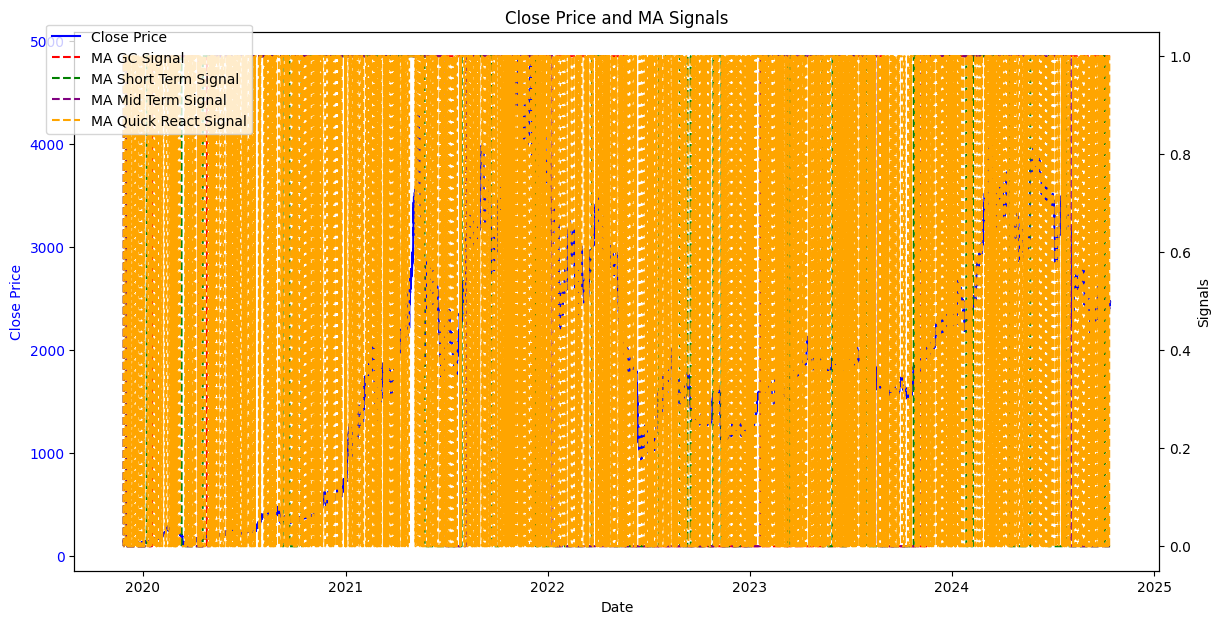

In [10]:
ma_gc = EWMACrossFactor(slow_window= 200 * time_scaler,fast_window=  50 * time_scaler)
ma_short_term = EWMACrossFactor(slow_window= 20 * time_scaler,fast_window=  5 * time_scaler)
ma_mid_term = EWMACrossFactor(slow_window= 50 * time_scaler,fast_window=  20 * time_scaler)
ma_quick_react = EWMACrossFactor(slow_window= 15 ,fast_window=  5)
# ma_3010 = EWMACrossFactor(slow_window= 30 ,fast_window= 10)
# ma_5020 = EWMACrossFactor(slow_window= 50 ,fast_window= 20)
# ma_fib = EWMACrossFactor(slow_window= 34 ,fast_window= 13)

signal_df['ma_gc_signal'] = await ma_gc.get_signal(signal_df['close'])
signal_df['ma_short_term_signal'] = await ma_short_term.get_signal(signal_df['close'])
signal_df['ma_mid_term_signal'] = await ma_mid_term.get_signal(signal_df['close'])
signal_df['ma_quick_react_signal'] = await ma_quick_react.get_signal(signal_df['close'])
# signal_df['ma_3010_signal'] = await ma_3010.get_signal(signal_df['close'])
# signal_df['ma_5020_signal'] = await ma_5020.get_signal(signal_df['close'])
# signal_df['ma_fib_signal'] = await ma_fib.get_signal(signal_df['close'])


fig, ax1 = plt.subplots(figsize=(14, 7))

# Plot close price
ax1.plot(signal_df.index, signal_df['close'], color='blue', label='Close Price')
ax1.set_xlabel('Date')
ax1.set_ylabel('Close Price', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create a second y-axis for the signals
ax2 = ax1.twinx()

ax2.plot(signal_df.index, signal_df['ma_gc_signal'], color='red', label='MA GC Signal', linestyle='--')
ax2.plot(signal_df.index, signal_df['ma_short_term_signal'], color='green', label='MA Short Term Signal', linestyle='--')
ax2.plot(signal_df.index, signal_df['ma_mid_term_signal'], color='purple', label='MA Mid Term Signal', linestyle='--')
ax2.plot(signal_df.index, signal_df['ma_quick_react_signal'], color='orange', label='MA Quick React Signal', linestyle='--')
# ax2.plot(signal_df.index, signal_df['ma_3010_signal'], color='black', label='MA 30/10 Signal', linestyle='--')
# ax2.plot(signal_df.index, signal_df['ma_5020_signal'], color='brown', label='MA 50/20 Signal', linestyle='--')
# ax2.plot(signal_df.index, signal_df['ma_fib_signal'], color='yellow', label='MA Fib Signal', linestyle='--')

ax2.set_ylabel('Signals', color='black')
ax2.tick_params(axis='y', labelcolor='black')

# Add legends
fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))

plt.title('Close Price and MA Signals')

plt.show()


In [11]:
target = 'returns_direction'
rsi_features = [x for x in  signal_df.columns if x != target]
print(rsi_features)

features = rsi_features
# Define the window size for sequences
window_size = 5 * 24 if timeframe == '1h' else 24
data = signal_df.copy()

# Handle NaN and infinity values in the data
data.replace([np.inf, -np.inf], np.nan, inplace=True)
data.fillna(data.mean(), inplace=True)

# Normalize the features
scaler = MinMaxScaler()
data[features] = scaler.fit_transform(data[features])

# Create sequences for Conv-LSTM
def create_sequences(data, features, target, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[features].iloc[i:i + window_size].values)
        y.append(data[target].iloc[i + window_size])
    return np.array(X), np.array(y)

# Prepare training and testing datasets
X, y = create_sequences(data, features, target, window_size)

# Split the data into training and testing sets
split_idx = int(0.8 * len(X))
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

# Flatten y_train and y_test
y_train = y_train.flatten()
y_test = y_test.flatten()

# Calculate class weights to handle class imbalance
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = dict(enumerate(class_weights))

# Model Definition
model = Sequential([
    Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(window_size, len(features))),
    BatchNormalization(),
    Dropout(0.2),
    LSTM(50, activation='tanh', return_sequences=False),
    Dropout(0.2),
    Dense(1, activation='sigmoid')  # Sigmoid activation for binary classification
])

# Compile the model with gradient clipping to prevent exploding gradients
optimizer = Adam(learning_rate=0.0001, clipnorm=1.0)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), class_weight=class_weights_dict)

# Evaluate the model
eval_results = model.evaluate(X_test, y_test)
print(f'Test Loss: {eval_results[0]}, Test Accuracy: {eval_results[1]}')


['close', 'ma_signal', 'macd_signal', 'bband_signal', 'rsi_signal', 'returns', 'volatility', 'volume', 'rsi_2w_signal', 'rsi_1w_signal', 'rsi_05d_signal', 'rsi_1d_signal', 'rsi_4d_signal', 'ma_gc_signal', 'ma_short_term_signal', 'ma_mid_term_signal', 'ma_quick_react_signal']


c:\code\crypto\ml-lecture\venv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
1066/1066 ━━━━━━━━━━━━━━━━━━━━ 25s 21ms/step - accuracy: 0.5070 - loss: 0.7070 - val_accuracy: 0.5016 - val_loss: 0.6949
Epoch 2/50
1066/1066 ━━━━━━━━━━━━━━━━━━━━ 25s 23ms/step - accuracy: 0.5022 - loss: 0.7003 - val_accuracy: 0.5039 - val_loss: 0.6946
Epoch 3/50
1066/1066 ━━━━━━━━━━━━━━━━━━━━ 24s 23ms/step - accuracy: 0.5006 - loss: 0.7005 - val_accuracy: 0.5091 - val_loss: 0.6946
Epoch 4/50
1066/1066 ━━━━━━━━━━━━━━━━━━━━ 24s 23ms/step - accuracy: 0.5096 - loss: 0.6972 - val_accuracy: 0.5020 - val_loss: 0.6942
Epoch 5/50
1066/1066 ━━━━━━━━━━━━━━━━━━━━ 24s 22ms/step - accuracy: 0.5059 - loss: 0.6972 - val_accuracy: 0.5080 - val_loss: 0.6936
Epoch 6/50
1066/1066 ━━━━━━━━━━━━━━━━━━━━ 25s 23ms/step - accuracy: 0.5097 - loss: 0.6965 - val_accuracy: 0.5087 - val_loss: 0.6940
Epoch 7/50
1066/1066 ━━━━━━━━━━━━━━━━━━━━ 25s 23ms/step - accuracy: 0.5117 - loss: 0.6961 - val_accuracy: 0.5056 - val_loss: 0.6942
Epoch 8/50
1066/1066 ━━━━━━━━━━━━━━━━━━━━ 25s 23ms/step - accuracy: 0.5137 -